In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

Bad pipe message: %s [b' 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Sa']
Bad pipe message: %s [b'ri/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/', b'ng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nA']
Bad pipe message: %s [b'ept-Language: en-US,en;q=0.9\r\nPriority: u=0, i\r\nReferer: https://studio.firebase.google.com/\r\nSec-', b'-Ua: "Chromium";v="136", "Google Chrome";v="136", "Not.A/Brand";v=']
Bad pipe message: %s [b'9"\r\nSec-Ch-Ua-Arch: "x86"\r\nSec-Ch', b'a-Bitness: "64"\r\nSec-Ch-Ua-Form-Factors: "De', b'top"\r\nSec-Ch-Ua-Full-Version: "136.0.7103.114"\r\nSec-Ch-Ua-Full-Version-List: "Chromium";v="136.0.7103.114", "Googl', b'Chrome";v="136.0.7103.114", "Not.A/Brand";v="99.0.0.0"\r\nSec-Ch-Ua-Mobile: ?0\r\nSec-Ch-Ua-Model: ""\r\nS']
Bad pipe message: %s [b'-Ch-Ua-Platform: "Windows"\r\nSec-Ch-Ua-Platform-Version: "15.0.0"\r\nSec-Ch-Ua-Wow64:

In [2]:
CATEGORIES = ["top_10", "bottom_10", "top_10_aug", "top_10_aut"]
SEAS_START, SEAS_END = "2021-08-01", "2024-08-31"
PERIOD = 12     # monthly data

In [3]:
df = (
    pd.read_csv("data/output/time_series.csv")
    .query(f'date >= "{SEAS_START}"')
    .assign(date=lambda x: pd.to_datetime(x['date'], errors='coerce'))
    .sort_values("date")
)

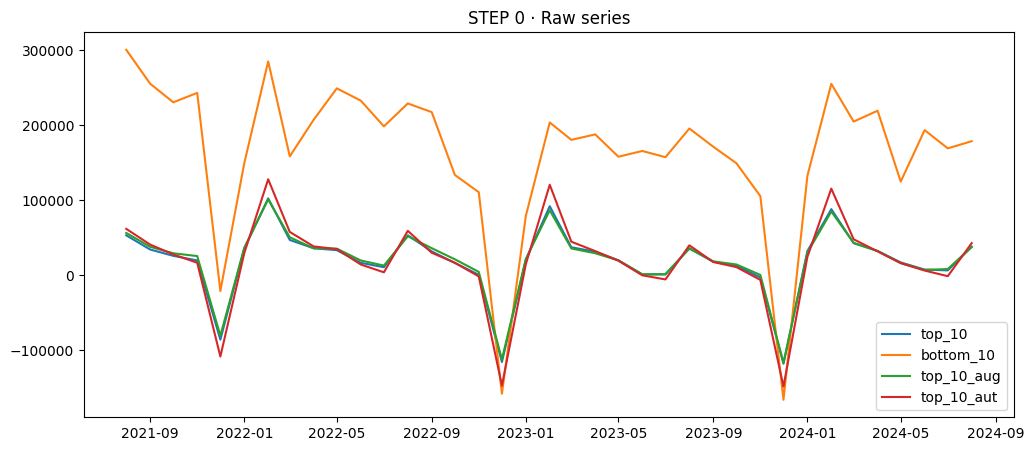

In [4]:
###############################################################
#########  1. BASIC PLOT:  raw normalized job flow series   ###
###############################################################

# Centers and normalizes the data according to the z-score for the category
plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    sub = df[df["cat"] == cat]
    plt.plot(sub["date"], sub["net_jobs"], label=cat)
plt.title("STEP 0 · Raw series")
plt.legend(); plt.show()

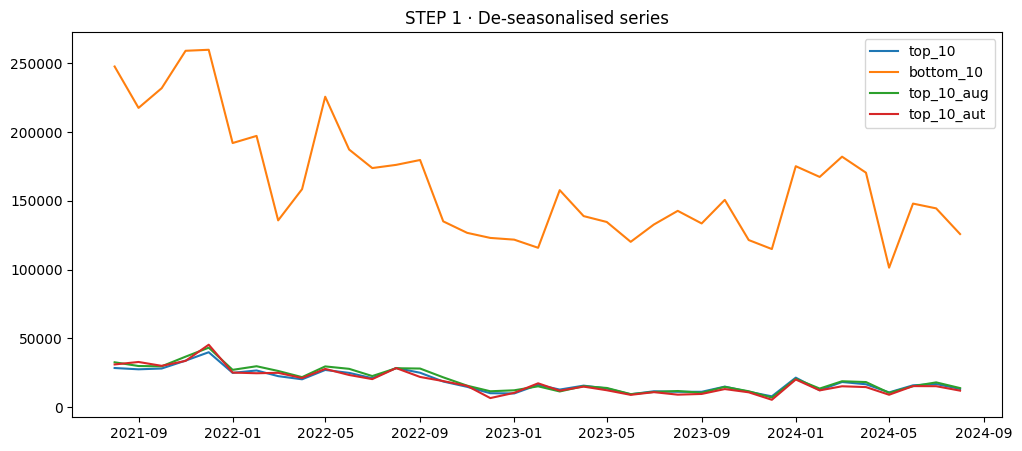

In [5]:
## 2. de-seasonalise via STL (monthly means) ####################3
seasonal_means = {}
for cat in CATEGORIES:
    series = (
                df
                .loc[
                      (df["cat"] == cat) & df["date"].between(SEAS_START, SEAS_END),
                      ["date", "net_jobs"]
                    ]
                .set_index("date")["net_jobs"]
                .asfreq("MS")
                .interpolate()
            )
    
    stl = STL(series, period=PERIOD).fit()
    
    seasonal_means[cat] = stl.seasonal.groupby(stl.seasonal.index.month).mean()

df["seasonal"] = df.apply(lambda r: seasonal_means[r["cat"]].loc[r["date"].month], axis=1)
df["net_jobs_dS"]   = df["net_jobs"] - df["seasonal"]

plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    plt.plot(df.loc[df["cat"] == cat, "date"],
             df.loc[df["cat"] == cat, "net_jobs_dS"], label=cat)
plt.title("STEP 1 · De-seasonalised series")
plt.legend(); plt.show()

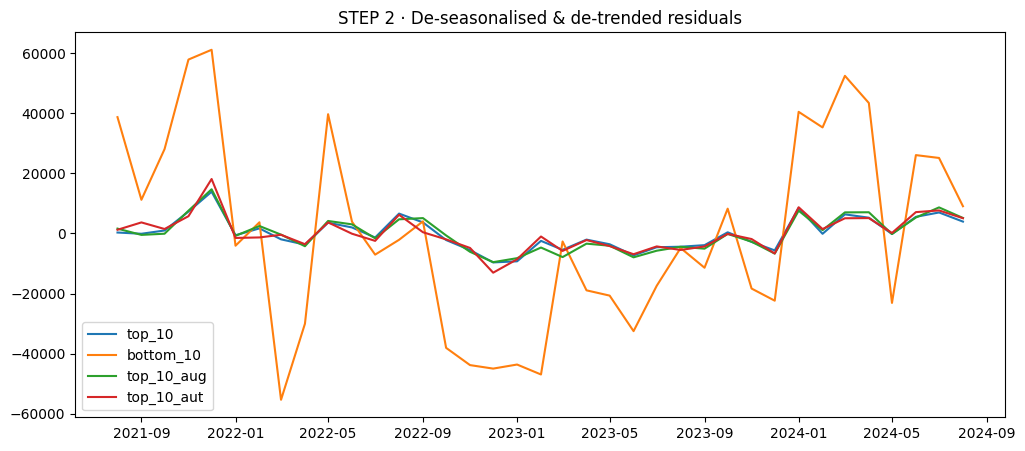

In [6]:
############ 3. remove constant / linear drift ###################################
df["t"] = (df["date"] - df["date"].min()).dt.days / 30   # months

lin_drift = {}

for cat in CATEGORIES:
    mask = df["cat"] == cat
    
    y = df.loc[mask, "net_jobs_dS"]
    X = sm.add_constant(df.loc[mask, ["t"]])

    ols = sm.OLS(y, X).fit()
    df.loc[mask, "net_jobs_dS_dT"] = y - ols.fittedvalues
    lin_drift[cat] = {"trend": ols}

plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    plt.plot(df.loc[df["cat"] == cat, "date"],
             df.loc[df["cat"] == cat, "net_jobs_dS_dT"], label=cat)
plt.title("STEP 2 · De-seasonalised & de-trended residuals")
plt.legend(); plt.show()

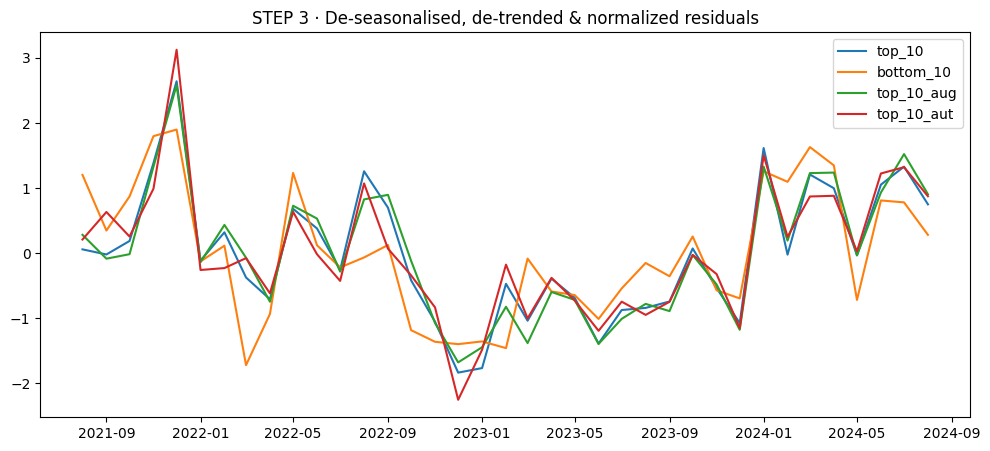

In [7]:
df = df.assign(
        net_jobs_dS_dT_norm=lambda x: (
                x["net_jobs_dS_dT"] - x.groupby("cat")["net_jobs_dS_dT"].transform("mean"))\
                / x.groupby("cat")["net_jobs_dS_dT"].transform("std")
            )

plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    plt.plot(df.loc[df["cat"] == cat, "date"],
             df.loc[df["cat"] == cat, "net_jobs_dS_dT_norm"], label=cat)
plt.title("STEP 3 · De-seasonalised, de-trended & normalized residuals")
plt.legend(); plt.show()

In [8]:
# ───── 4. fit AR(p) on residuals, choose p by AIC 1…6 ───────────────────
for cat in CATEGORIES:
    resid = (df.loc[df["cat"] == cat, ["date", "net_jobs_dS_dT_norm"]]
               .set_index("date")["net_jobs_dS_dT_norm"]
               .asfreq("MS"))          # give AutoReg a proper index

    best_aic, best_p, best_model = np.inf, None, None
    for p in range(1, 13):
        mod = AutoReg(resid, lags=p, old_names=False).fit()
        if mod.aic < best_aic:
            best_aic, best_p, best_model = mod.aic, p, mod

    p_adf = adfuller(resid.dropna())[1]
    print(f"{cat:<12} | ADF p={p_adf:.3f} | AR({best_p}) AIC={best_aic:.2f}")

    lin_drift[cat]["ar"] = best_model

top_10       | ADF p=0.518 | AR(12) AIC=68.05
bottom_10    | ADF p=0.013 | AR(12) AIC=73.01
top_10_aug   | ADF p=0.021 | AR(12) AIC=67.96
top_10_aut   | ADF p=0.774 | AR(12) AIC=65.65


In [9]:
# ───── 5. ARIMA(1,0,1) on residuals ───────────────────────────
for cat in CATEGORIES:
    resid = (df.loc[df['cat'] == cat, ['date', 'net_jobs_dS_dT_norm']]
               .set_index('date')['net_jobs_dS_dT_norm']
               .asfreq('MS'))
    arima = ARIMA(resid, order=(1,0,1)).fit()
    print(f'{cat:<12} | ARIMA(1,0,1) AIC={arima.aic:.2f}')
    lin_drift[cat]['arima'] = arima


top_10       | ARIMA(1,0,1) AIC=101.82
bottom_10    | ARIMA(1,0,1) AIC=99.76
top_10_aug   | ARIMA(1,0,1) AIC=99.12
top_10_aut   | ARIMA(1,0,1) AIC=103.28


In [24]:
df['t']

76      0.000000
77      0.000000
78      0.000000
79      0.000000
80      1.033333
         ...    
219    35.500000
221    36.533333
222    36.533333
220    36.533333
223    36.533333
Name: t, Length: 148, dtype: float64

In [26]:
# Make sure 'group' is categorical
df_ = (
    df
    .copy()
    [df['cat'].isin(['top_10_aug', 'bottom_10'])]
    .assign(cat = lambda x: x['cat'].astype('category'))
    .assign(
        net_jobs_dS_N=lambda x: x.groupby('cat')['net_jobs_dS'].transform(
                        lambda g: (g - g.mean()) / g.std()
                    )
            )
)

# Fit the interaction model: value ~ time + group + time:group
model = sm.formula.ols("net_jobs_dS_N ~ t + cat + t:cat", data=df_).fit(cov_type='HC1')

# Display full regression output
print(model.summary())

# Extract the slope difference coefficient and p-value
interaction_term = [col for col in model.params.index if 't:cat' in col]
if interaction_term:
    slope_diff = model.params[interaction_term[0]]
    pval = model.pvalues[interaction_term[0]]
    print(f"\nSlope difference (interaction): {slope_diff:.4f}")
    print(f"P-value: {pval:.4g}")
else:
    print("Interaction term not found – check variable naming.")

                            OLS Regression Results                            
Dep. Variable:          net_jobs_dS_N   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     24.01
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           8.58e-11
Time:                        13:51:13   Log-Likelihood:                -78.111
No. Observations:                  74   AIC:                             164.2
Df Residuals:                      70   BIC:                             173.4
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0848    

/tmp/ipykernel_221/2805883947.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  net_jobs_dS_N=lambda x: x.groupby('cat')['net_jobs_dS'].transform(


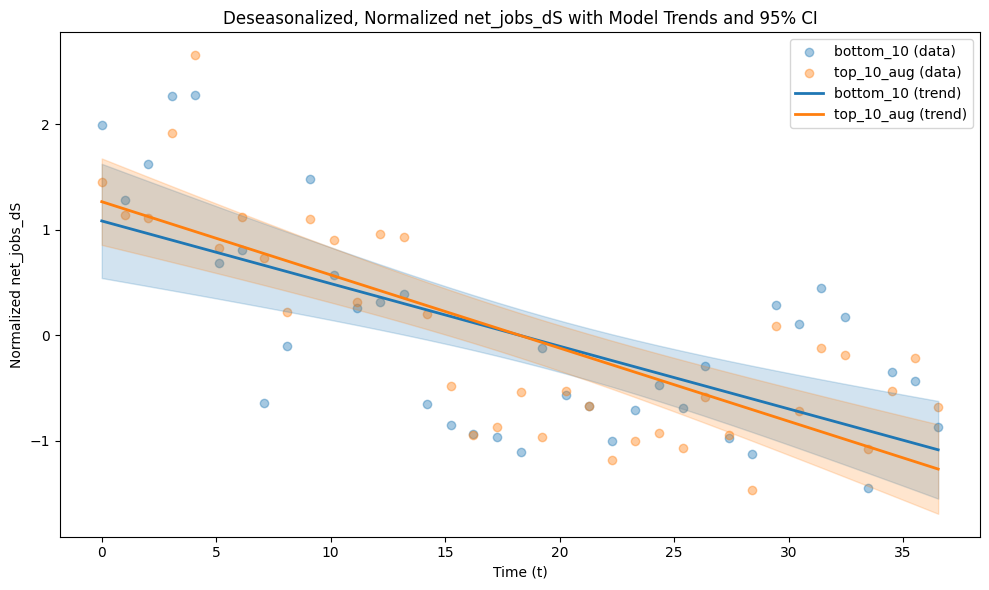

In [29]:
# Prepare prediction data for plotting trend lines
t_values = np.sort(df_['t'].unique())
cats = df_['cat'].cat.categories

pred_data = pd.DataFrame([(t, c) for c in cats for t in t_values], columns=['t', 'cat'])
pred_data['cat'] = pred_data['cat'].astype('category').cat.reorder_categories(cats)

# Get predictions with confidence intervals
pred_results = model.get_prediction(pred_data)
pred_summary = pred_results.summary_frame(alpha=0.05)  # 95% CI

pred_data['trend'] = pred_summary['mean']
pred_data['ci_lower'] = pred_summary['mean_ci_lower']
pred_data['ci_upper'] = pred_summary['mean_ci_upper']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'bottom_10': 'tab:blue', 'top_10_aug': 'tab:orange'}

# Scatter plot of normalized deseasonalized data points
for cat in cats:
    subset = df_[df_['cat'] == cat]
    ax.scatter(subset['t'], subset['net_jobs_dS_N'], label=f"{cat} (data)", color=colors[cat], alpha=0.4)

# Plot trend lines with confidence bands
for cat in cats:
    subset = pred_data[pred_data['cat'] == cat]
    ax.plot(subset['t'], subset['trend'], label=f"{cat} (trend)", color=colors[cat], linewidth=2)
    ax.fill_between(subset['t'], subset['ci_lower'], subset['ci_upper'], color=colors[cat], alpha=0.2)

ax.set_title("Deseasonalized, Normalized net_jobs_dS with Model Trends and 95% CI")
ax.set_xlabel("Time (t)")
ax.set_ylabel("Normalized net_jobs_dS")
ax.legend()
plt.tight_layout()
plt.show()
